In [17]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Load the CSV file
df = pd.read_csv('Cleaned_Economic_News_Relabeled.csv', encoding='ISO-8859-1')

# Step 2: Drop rows where any of the relevant columns have NaN or empty values
df_cleaned = df.dropna(subset=['headline', 'sentiment'])

# Optionally, remove any rows where the headline column is empty or contains only whitespace
df_cleaned = df_cleaned[df_cleaned['headline'].str.strip().astype(bool)]

# Step 3: Create a new column 'sentiment' based on the positivity score
def categorize_sentiment(positivity):
    if positivity == -1:
        return 'negative'
    elif positivity == 0:
        return 'neutral'
    elif positivity == 1:
        return 'positive'
    else:
        return None  # In case there are out-of-range values

df_cleaned['sentiment'] = df_cleaned['sentiment'].apply(categorize_sentiment)

# Step 4: Preprocess the headline
def preprocess_headline(headline):
    # Convert text to lowercase
    headline = headline.lower()
    
    # Replace numbers with <NUMBER>
    headline = re.sub(r'\b\d+(\.\d+)?\b', '<NUMBER>', headline)
    
    # Replace percentages with <PERCENTAGE>
    headline = re.sub(r'\d+(\.\d+)?%', '<PERCENTAGE>', headline)
    
    # Replace other numerical representations (e.g., currency) if necessary
    headline = re.sub(r'\$\d+(\.\d+)?', '<CURRENCY>', headline)  # Replace currency amounts
    headline = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '<DATE>', headline)  # Replace dates

    # Remove non-alphanumeric characters (except spaces and punctuation)
    headline = re.sub(r'[^\w\s\.,!?\'":;()-]', '', headline)

    # Optional: Remove excessive whitespace
    headline = re.sub(r'\s+', ' ', headline).strip()
    
    return headline


neutral     418
negative    418
positive    418
Name: sentiment, dtype: int64


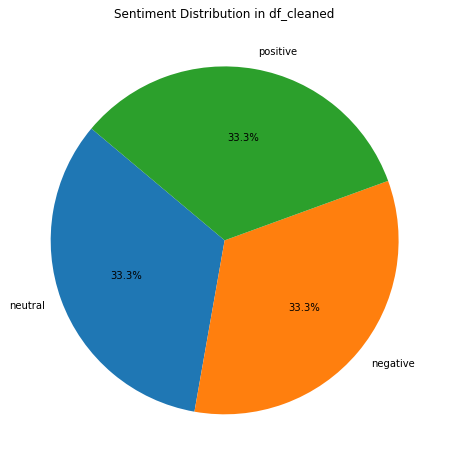

In [21]:
# Get the counts of each sentiment class
class_counts = df_cleaned['sentiment'].value_counts()

target_count = class_counts.min()
df_neutral = df_cleaned[df_cleaned['sentiment'] == 'neutral'].sample(target_count, random_state=42)
df_pos = df_cleaned[df_cleaned['sentiment'] == 'positive'].sample(target_count, random_state=42)
df_neg = df_cleaned[df_cleaned['sentiment'] == 'negative'].sample(target_count, random_state=42)

df_balanced = pd.concat([df_neg, df_pos,
                         df_neutral])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Count the occurrences of each sentiment
sentiment_counts = df_balanced['sentiment'].value_counts()
print(sentiment_counts)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in df_cleaned')
plt.show()


In [23]:
# apply preproccessing to balanced data
df_balanced['cleaned_headline'] = df_balanced['headline'].apply(preprocess_headline)

X = df_balanced['cleaned_headline']  
y = df_balanced['sentiment']  

Test Accuracy: 0.5219
Classification Report:
              precision    recall  f1-score   support

    negative       0.45      0.40      0.42        83
     neutral       0.56      0.57      0.56        84
    positive       0.55      0.60      0.57        84

    accuracy                           0.52       251
   macro avg       0.52      0.52      0.52       251
weighted avg       0.52      0.52      0.52       251



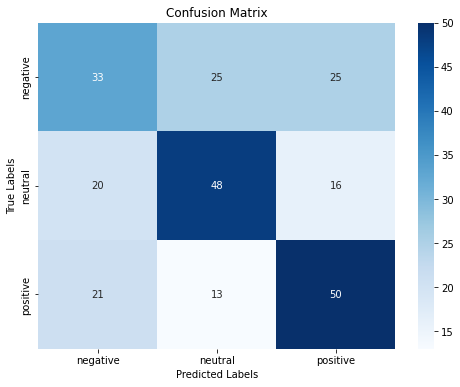

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test) 

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_tfidf)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()